# Lab 2: Grayscale Colorizer

# Exercise 1

## 1. Dataset and preprocessing
We use the CIFAR-10 dataset (60,000 colour images of size 32×32×3 in 10 classes).  
Pixels are normalised to the [0,1] range using `ToTensor()`.  
We merge the original train and test splits and randomly divide them into:
- 80% training
- 10% validation
- 10% test

This split is done with `random_split` from PyTorch.

In [36]:
import torch, torchvision
from torch.utils.data import random_split, DataLoader, ConcatDataset
from torchvision import datasets, transforms


transform = transforms.Compose([
    transforms.ToTensor(),                
])

all_data = ConcatDataset([
    datasets.CIFAR10(root="./data", train=True,  download=True, transform=transform),
    datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
])

n = len(all_data)

# Get sizes for train test and val
n_train = int(0.8 * n)
n_val   = int(0.1 * n)
n_test  = int(0.1 * n)

train_set, val_set, test_set = random_split(all_data, [n_train, n_val, n_test])

# DataLoaders, why do we shuffle only train?
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=128, shuffle=False)
test_loader  = DataLoader(test_set, batch_size=128, shuffle=False)

len(train_loader), len(val_loader), len(test_loader)


Files already downloaded and verified
Files already downloaded and verified


(375, 47, 47)


## 2. Convolutional autoencoder architecture

The autoencoder compresses 32×32 RGB images into a low-dimensional latent representation and then reconstructs them.

**Encoder:**
- Conv2d: 3 → 8 channels, 3×3 kernel, padding=1, ReLU
- MaxPool2d: 2×2 (32×32 → 16×16)
- Conv2d: 8 → 12 channels, 3×3 kernel, padding=1, ReLU
- MaxPool2d: 2×2 (16×16 → 8×8)
- Conv2d: 12 → 16 channels, 3×3 kernel, padding=1, ReLU  

The latent space has shape 8×8×16 = 1024 values per image.

**Decoder:**
- Upsample: factor 2 (8×8 → 16×16)
- Conv2d: 16 → 12 channels, 3×3, ReLU
- Upsample: factor 2 (16×16 → 32×32)
- Conv2d: 12 → 3 channels, 3×3, Sigmoid

We train the model to minimise the mean squared error between the input and output images.


In [37]:
import torch.nn as nn

# ------------------------ MAIN MODEL DEFINITION ------------------------ #
class ConvolutionAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

    
        #Auto encoder architecture
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3, stride=1, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride=2),
            nn.Conv2d(in_channels = 8, out_channels = 12, kernel_size = 3, stride=1, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(in_channels = 12, out_channels = 16, kernel_size = 3, stride=1, padding="same"),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(in_channels = 16, out_channels = 12, kernel_size = 3, stride=1, padding="same"),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(in_channels = 12, out_channels = 3, kernel_size = 3, stride=1, padding="same"),
            nn.ReLU()
            
        )

    def forward(self, x):
        h = self.encoder(x)
        out = self.decoder(h)
        # tuple (reconstruction, latent)
        return out, h

# ------------------------ SHALLOWER MODEL DEFINITION ------------------------ #
class ShallowConvolutionAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        h = self.encoder(x)
        out = self.decoder(h)
        return out, h

# ------------------------ DEEPER MODEL DEFINITION ------------------------ #
class DeepConvolutionAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(16, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(64, 32, 3, stride=1, padding=1),
            nn.ReLU(),

            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(32, 16, 3, stride=1, padding=1),
            nn.ReLU(),

            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(16, 3, 3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        h = self.encoder(x)
        out = self.decoder(h)
        return out, h


# ------------------------ BIGGER FILTER MODEL DEFINITION ------------------------ #

class BiggerFilterConvolutionAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(8, 16, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(16, 8, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(8, 3, 5, stride=1, padding=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        h = self.encoder(x)
        out = self.decoder(h)
        return out, h



## 3. Training procedure

We train with:
- Optimizer: Adam
- Learning rate: 1e-3
- Batch size: 128
- Number of epochs: 10

At each epoch we compute:
- **Training loss** on the training set
- **Validation loss** on the validation set

In [38]:
import torch
import torch.optim as optim

# GPU acceleration for faster training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device being used: {device}")

def train_model(model, train_loader, val_loader, epochs=10, learning_rate=0.01, device=device):

    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    validation_losses = []

    for e in range(epochs):
        model.train()
        current_loss = 0.0
        for batch_idx, (img, _) in enumerate(train_loader):
            
            img = img.to(device)
            # tuple returned from foward(x)
            reconstruction, latent = model(img)
            optimizer.zero_grad()

            # when the input equal to the target 
            loss = criterion(reconstruction, img)

            loss.backward()
            optimizer.step()

            current_loss += loss.item() * img.size(0)

        epoch_train_loss = current_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)


        model.eval()
        current_loss_val = 0.0

        with torch.no_grad():
            for img, _ in val_loader:
                img = img.to(device)
                reconstruction, latent = model(img)
                loss = criterion(reconstruction, img)
                current_loss_val += loss.item() * img.size(0)

        epoch_val_loss = current_loss_val / len(val_loader.dataset)
        validation_losses.append(epoch_val_loss)

        
        print(f"Epoch {e+1}/{epochs} "
            f"- Train loss: {epoch_train_loss:.4f}, Validation loss: {epoch_val_loss:.4f}")
        
    return model, train_losses, validation_losses



Device being used: cpu


In [ ]:
baseModel = ConvolutionAutoEncoder()
trainedModel, train_losses, validation_losses = train_model(baseModel, train_loader, val_loader, epochs=50, learning_rate=0.001, device=device)

# Saving the trained model
torch.save(trainedModel.state_dict(), 'Base_conv_autoencoder.pth')


Epoch 1/50 - Train loss: 0.0256, Validation loss: 0.0089
Epoch 2/50 - Train loss: 0.0078, Validation loss: 0.0071
Epoch 3/50 - Train loss: 0.0067, Validation loss: 0.0065
Epoch 4/50 - Train loss: 0.0062, Validation loss: 0.0060
Epoch 5/50 - Train loss: 0.0059, Validation loss: 0.0058
Epoch 6/50 - Train loss: 0.0057, Validation loss: 0.0057
Epoch 7/50 - Train loss: 0.0055, Validation loss: 0.0055
Epoch 8/50 - Train loss: 0.0053, Validation loss: 0.0053
Epoch 9/50 - Train loss: 0.0052, Validation loss: 0.0052
Epoch 10/50 - Train loss: 0.0051, Validation loss: 0.0052
Epoch 11/50 - Train loss: 0.0050, Validation loss: 0.0051
Epoch 12/50 - Train loss: 0.0049, Validation loss: 0.0049
Epoch 13/50 - Train loss: 0.0049, Validation loss: 0.0048
Epoch 14/50 - Train loss: 0.0048, Validation loss: 0.0050


## 4. Results

### 4.1 Loss curves

Figure 1 shows the evolution of the training and validation MSE loss over epochs.  
The validation loss decreases and then stabilises after about 10 epochs, which indicates that the autoencoder has converged.

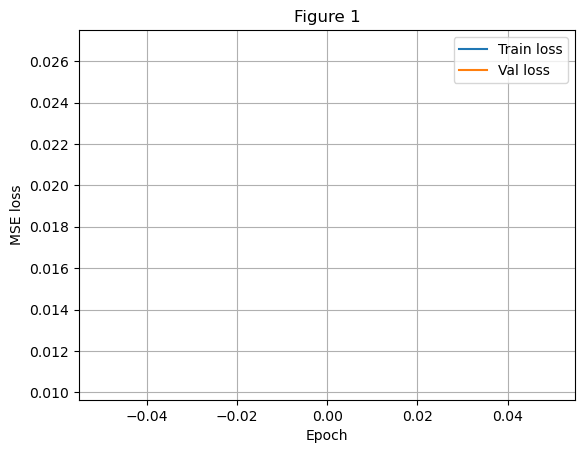

In [ ]:
import matplotlib.pyplot as plt
def plot_losses(train_losses, validation_losses):
    plt.figure()
    plt.plot(train_losses, label="Train loss")
    plt.plot(validation_losses, label="Val loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE loss")
    plt.legend()
    plt.grid(True)
    plt.title("Figure 1")
    plt.show()

plot_losses(train_losses, validation_losses)

### 4.2 Test performance

After training, we evaluate the model on the test set.  

In [ ]:
def evaluate_model(model, data_loader, device=device):
    model.eval()
    criterion = nn.MSELoss()
    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device)
            outputs, _ = model(images)
            loss = criterion(outputs, images)
            batch_size = images.size(0)
            total_loss += loss.item() * batch_size
            total_samples += batch_size

    return total_loss / total_samples

In [ ]:
test_loss = evaluate_model(trainedModel, test_loader)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.0103


### 4.3 Visual inspection

Figure 2 illustrates some original input images and their reconstructions.  
The reconstructions are slightly blurred but preserve the main objects and colours, which is expected for a simple convolutional autoencoder.


In [ ]:
import torch
import matplotlib.pyplot as plt

def show_reconstruction(model, test_loader, device=device, num_images=5, title=""):
    model.eval()

    # 1. Take a single batch from the test (or val) loader
    img, _ = next(iter(test_loader)) 
    img = img.to(device)

    # 2. Get reconstructions
    with torch.no_grad():
        reconstruction, latent = model(img)         

    # 3. Move to CPU and (optionally) undo normalization
    orig = img.cpu()
    rec  = reconstruction.cpu()

    # 4. Plot first 7 originals and their reconstructions
    n_show = 7
    fig, ax = plt.subplots(2, n_show, figsize=(15, 4), dpi=250)

    for i in range(n_show):
        # [C, H, W] -> [H, W, C]
        img_np = orig[i].numpy().transpose((1, 2, 0))
        rec_np = rec[i].numpy().transpose((1, 2, 0))

        ax[0, i].imshow(img_np)
        ax[0, i].axis('off')

        ax[1, i].imshow(rec_np)
        ax[1, i].axis('off')
    ax[0, 0].set_title('Original')
    ax[1, 0].set_title('Reconstructed')
    plt.tight_layout()
    plt.show()

    # remember to add title to the graph 



Training model: Base
Epoch 1/1 - Train loss: 0.0255, Validation loss: 0.0104

Training model: Simple
Epoch 1/1 - Train loss: 0.0239, Validation loss: 0.0106

Training model: Deep
Epoch 1/1 - Train loss: 0.0206, Validation loss: 0.0135

Training model: WideKernel
Epoch 1/1 - Train loss: 0.0158, Validation loss: 0.0108


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.11632911..1.0211115].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0122062].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.029488318..1.0710971].



 Model Performance Summary:
Base            | Test Loss: 0.010264
Simple          | Test Loss: 0.010583
Deep            | Test Loss: 0.013244
WideKernel      | Test Loss: 0.010676


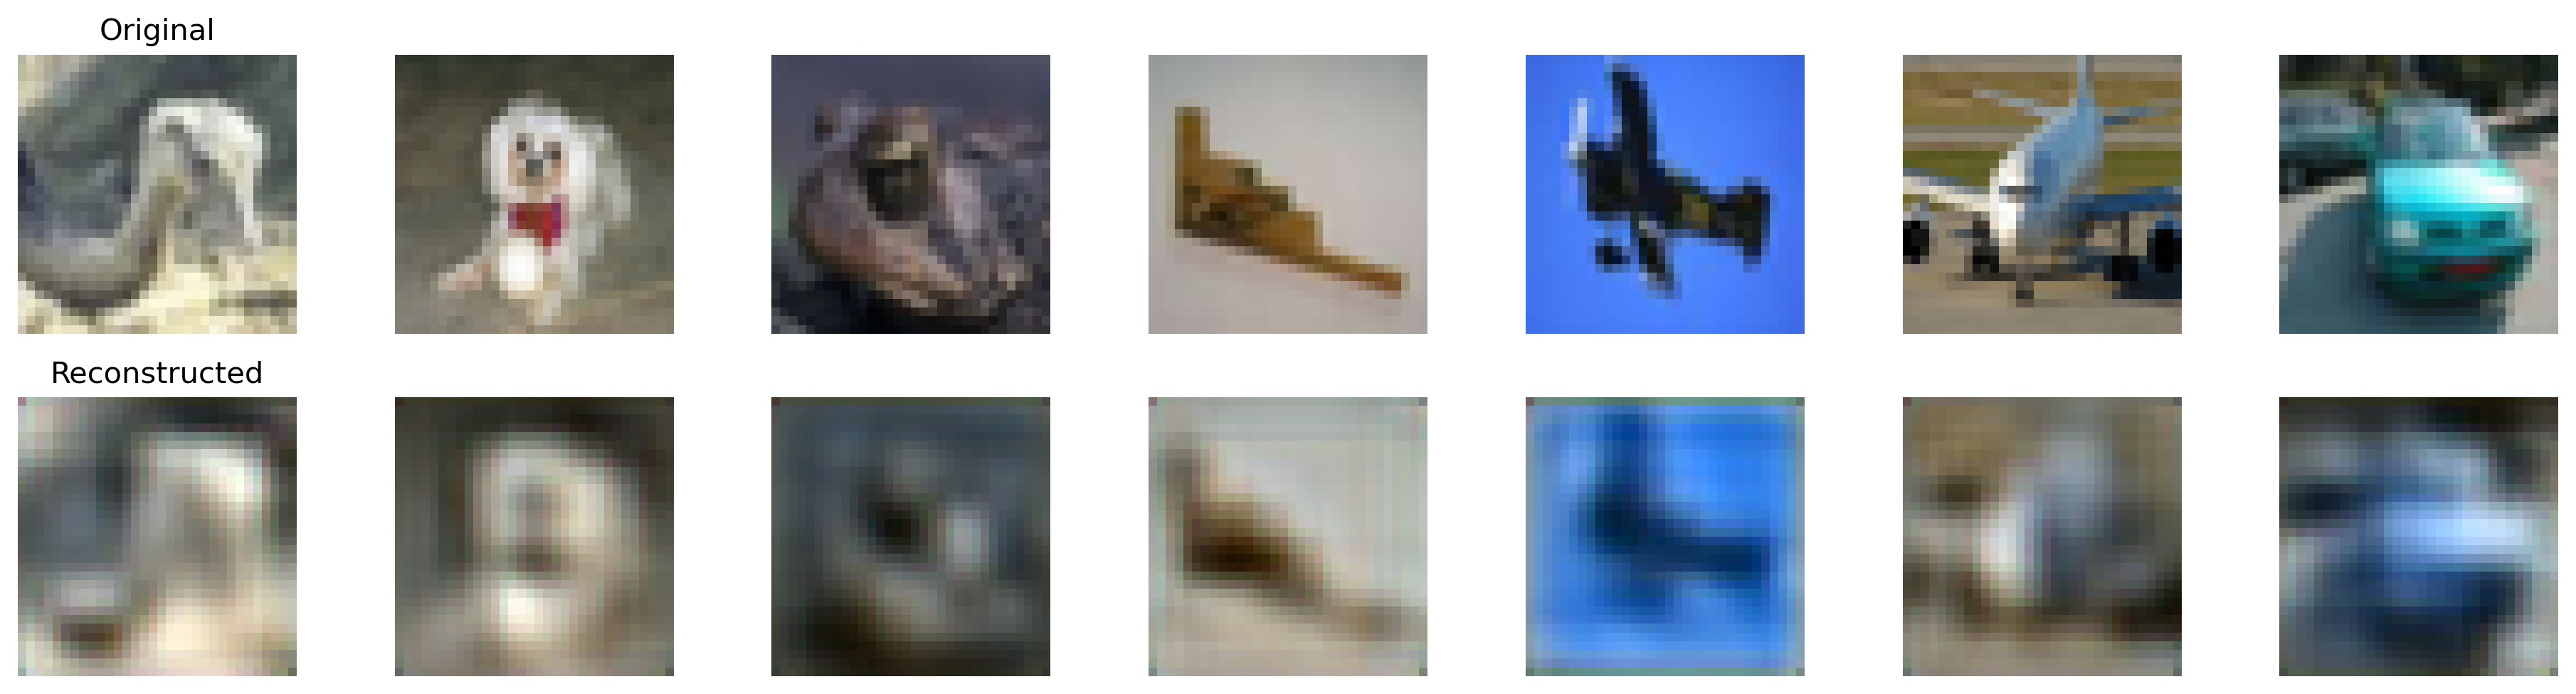

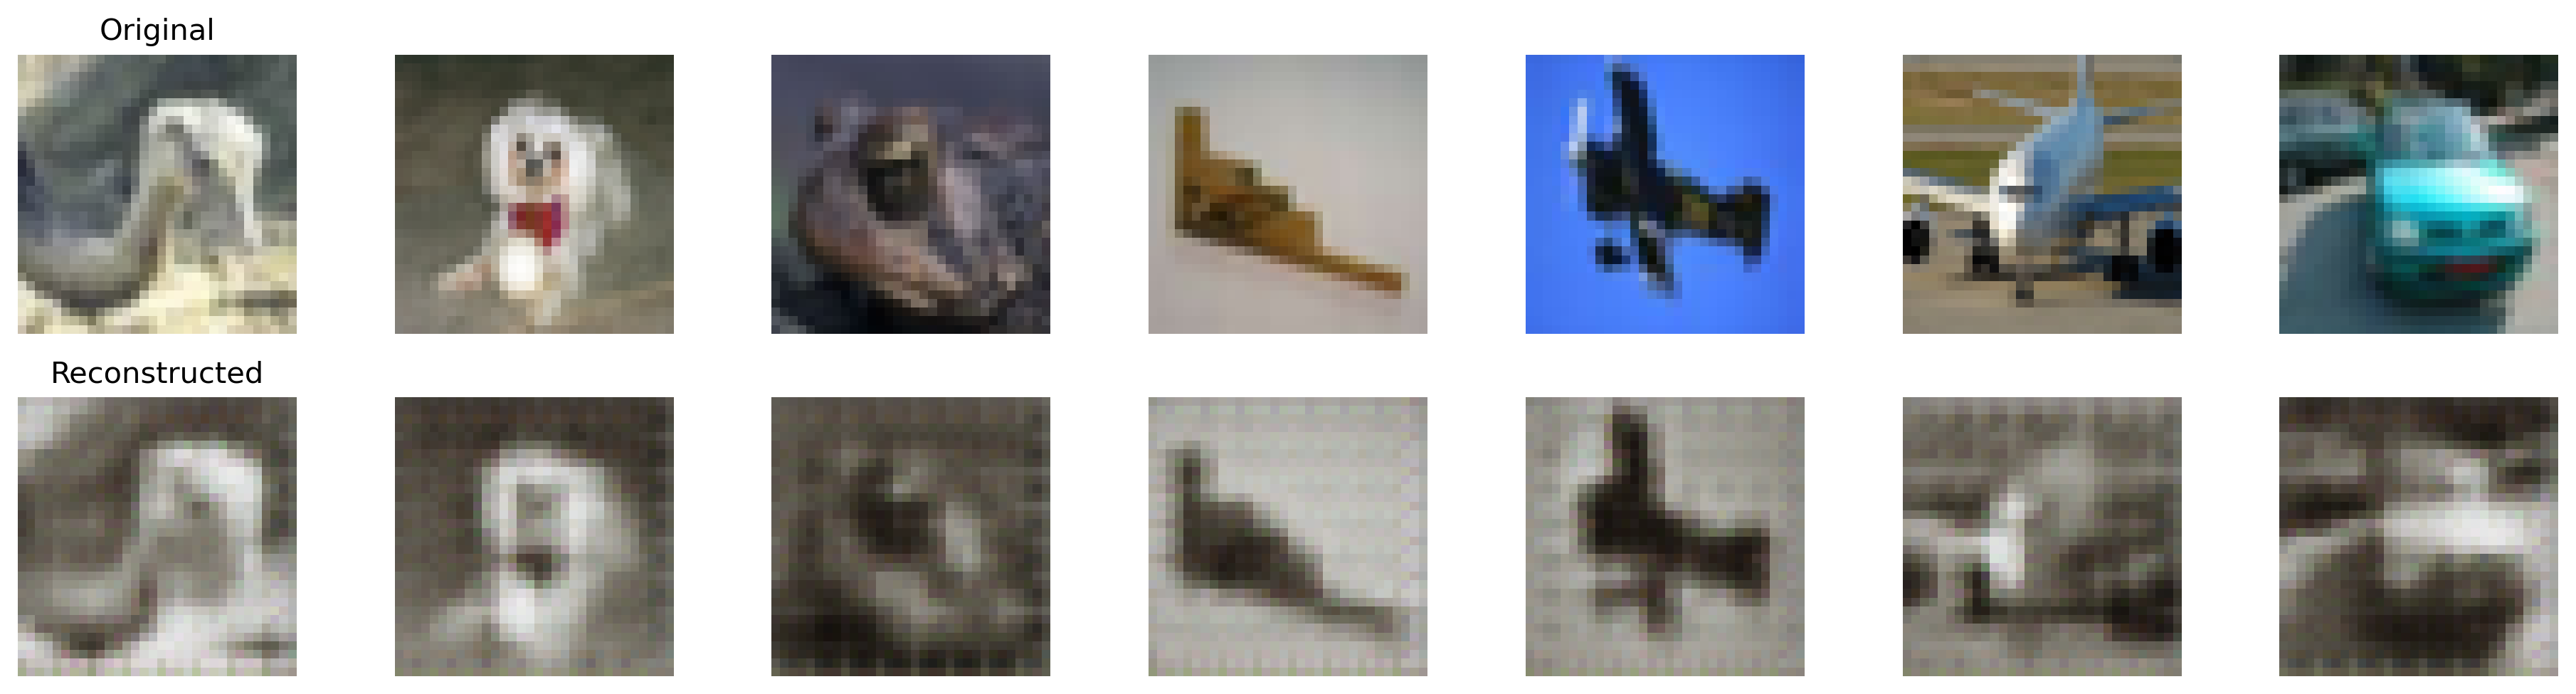

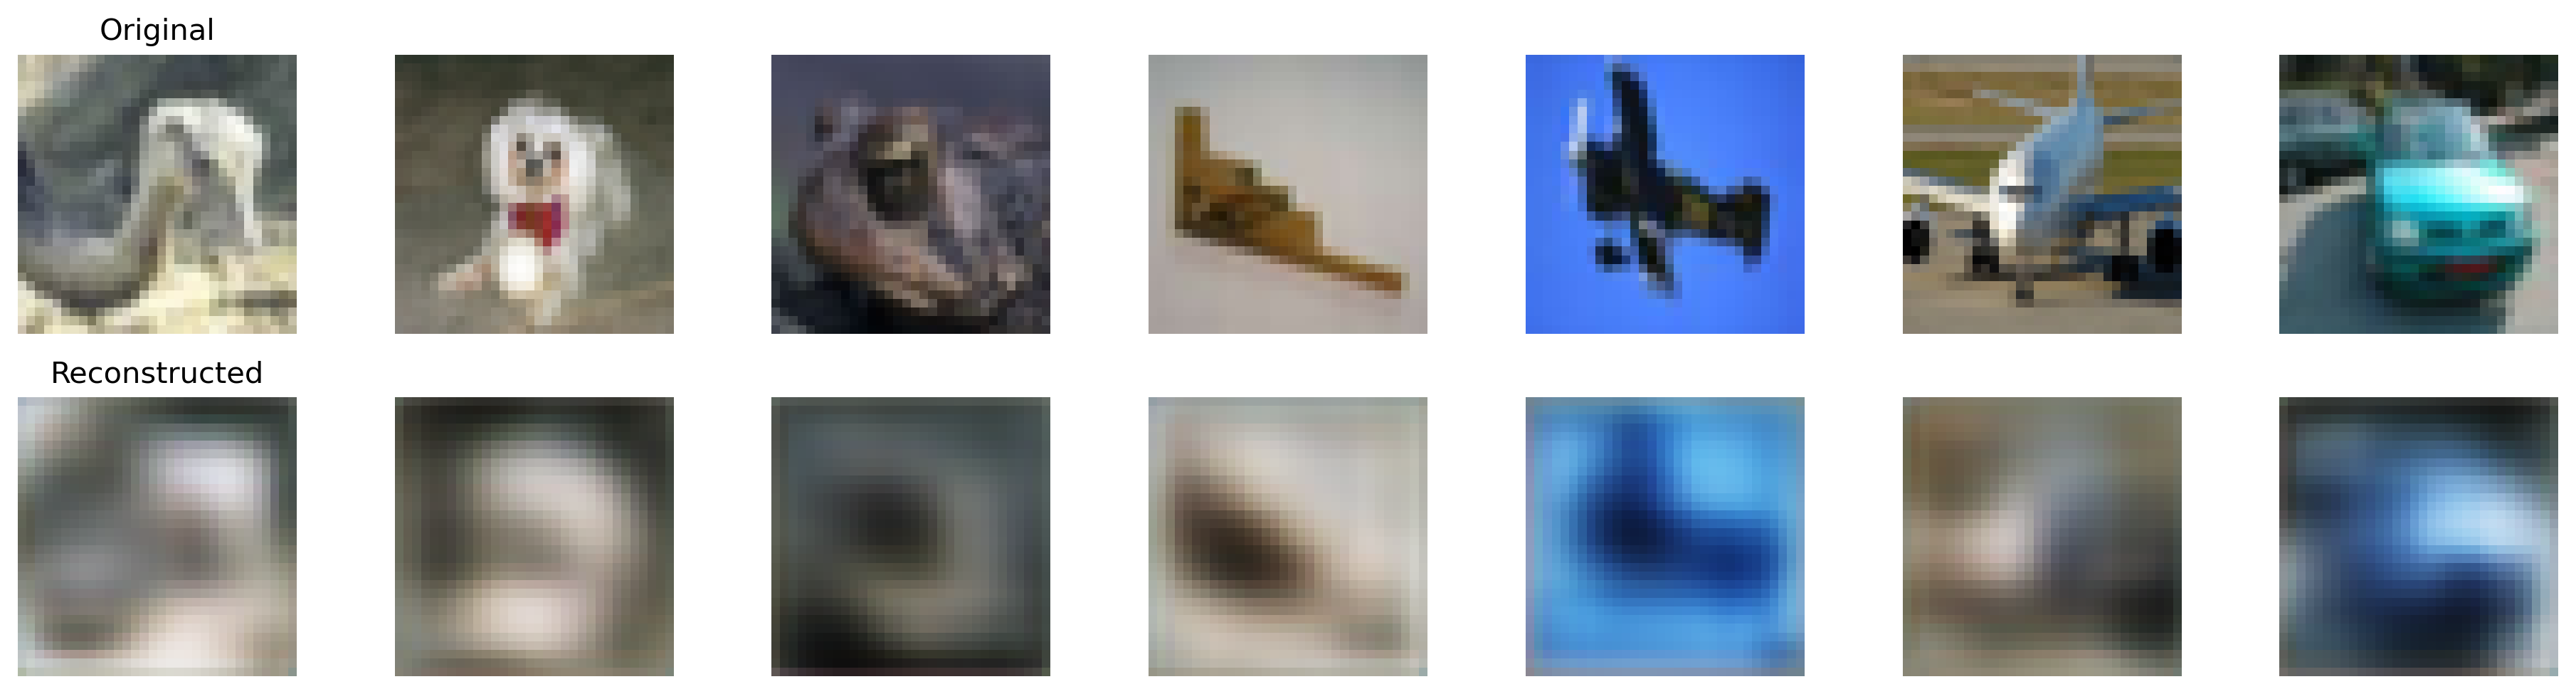

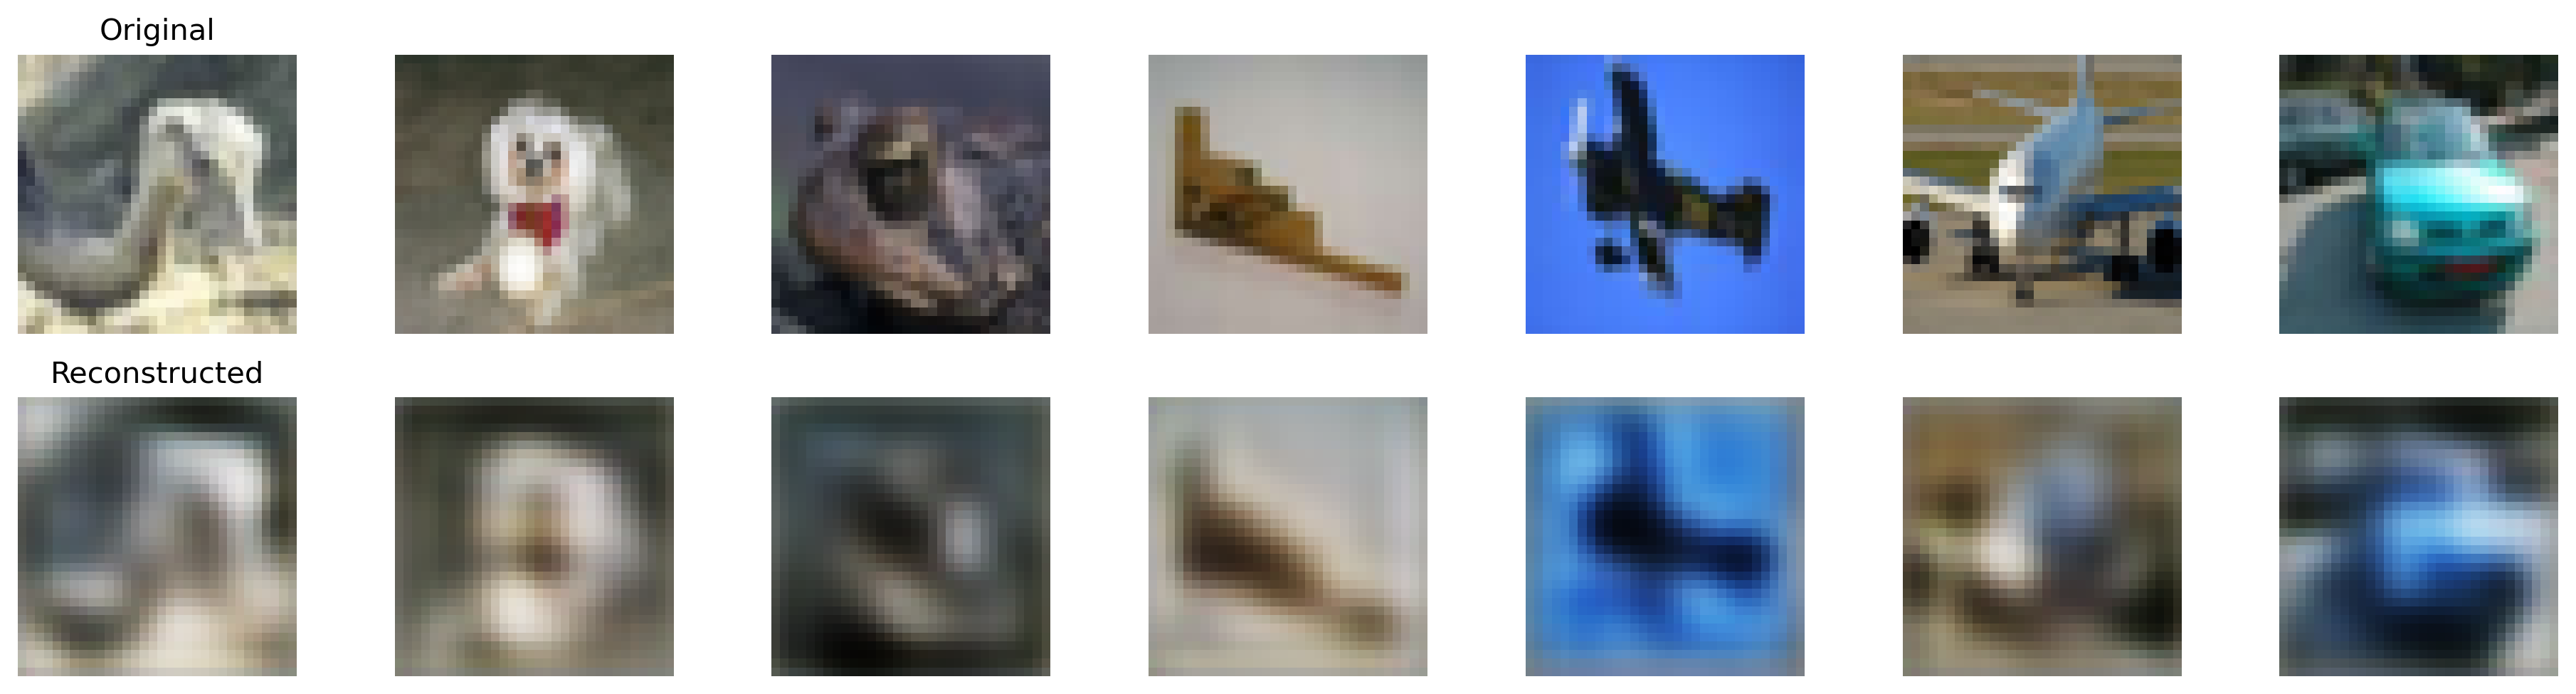

In [ ]:
models_to_test = {
    "Base": ConvolutionAutoEncoder(),
    "Simple": ShallowConvolutionAutoEncoder(),
    "Deep": DeepConvolutionAutoEncoder(),
    "WideKernel": BiggerFilterConvolutionAutoEncoder()
}

trained_models = {}

results = {}

for name, model in models_to_test.items():
    print(f"\n======================")
    print(f"Training model: {name}")
    print(f"======================")

    trained_model, train_losses, validation_losses = train_model(model, train_loader, val_loader, epochs=10, learning_rate=1e-3)
    
    # Saving the trained model
    torch.save(trained_model.state_dict(), f'{name.lower()}_conv_autoencoder.pth')

    test_loss = evaluate_model(trained_model, test_loader)

    results[name] = {
        "model": trained_model,
        "val_loss": validation_losses,
        "test_loss": test_loss
    }



# Show summary of results
print("\n Model Performance Summary:")
for name, entry in results.items():
    print(f"{name:<15} | Test Loss: {entry['test_loss']:.6f}")

# Optionally, show all the reconstructions
for name, entry in results.items():
    model = entry["model"]
    show_reconstruction(model, test_loader, device=device, title=f"Reconstruction - {name}")


## 3.1 Baseline colorization: grayscale → RGB

In this baseline, we convert each CIFAR-10 image to grayscale (and replicate it
to 3 channels) and train the convolutional autoencoder from Exercise 2 to reconstruct
the original RGB image.

- **Input**: grayscale image replicated to 3 channels (shape [3, 32, 32])
- **Target**: original RGB image (shape [3, 32, 32])
- **Loss**: mean squared error (MSE)
- **Splits**: 80% train, 10% validation, 10% test (as before)


In [ ]:
# --- Cell: dataset for baseline gray->RGB colorization ---
import torch
from torch.utils.data import Dataset, ConcatDataset, random_split, DataLoader
from torchvision import datasets, transforms

# Base CIFAR-10 without transforms (so we can build paired input/target)
base_train = datasets.CIFAR10(root="./data", train=True,  download=True, transform=None)
base_test  = datasets.CIFAR10(root="./data", train=False, download=True, transform=None)

class GrayToColorCIFAR(Dataset):
    """
    Returns:
      x: grayscale image replicated to 3 channels, shape [3, 32, 32], in [0,1]
      y: original RGB image, shape [3, 32, 32], in [0,1]
    """
    def __init__(self, baseds):
        self.baseds = baseds
        self.t_in  = transforms.Compose([
            transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor()
        ])
        self.t_tgt = transforms.ToTensor()

    def __len__(self): 
        return len(self.baseds)

    def __getitem__(self, idx):
        img, _ = self.baseds[idx]     # PIL RGB
        x = self.t_in(img)            # [3,H,W] grayscale replicated to 3ch
        y = self.t_tgt(img)           # [3,H,W] RGB
        return x, y

# Merge original train+test and re-split 80/10/10
all_color = ConcatDataset([GrayToColorCIFAR(base_train), GrayToColorCIFAR(base_test)])
n = len(all_color)
n_train = int(0.8 * n)
n_val   = int(0.1 * n)
n_test  = n - n_train - n_val

train_set_c, val_set_c, test_set_c = random_split(all_color, [n_train, n_val, n_test])

batch_size = 128
train_loader_c = DataLoader(train_set_c, batch_size=batch_size, shuffle=True,  num_workers=0)
val_loader_c   = DataLoader(val_set_c,   batch_size=batch_size, shuffle=False, num_workers=0)
test_loader_c  = DataLoader(test_set_c,  batch_size=batch_size, shuffle=False, num_workers=0)

print("Baseline gray->RGB dataset sizes:",
      len(train_set_c), len(val_set_c), len(test_set_c))


Files already downloaded and verified
Files already downloaded and verified
Baseline gray->RGB dataset sizes: 48000 6000 6000


We now train the Y→CbCr autoencoder with the same settings
(Adam, MSE, 15 epochs) and record training and validation losses.


In [ ]:
# --- Cell: setup baseline colorizer training ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model_c = ConvolutionAutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer_c = optim.Adam(model_c.parameters(), lr=1e-3)
epochs_c = 50


Device: cpu


In [ ]:
# --- Cell: train baseline gray->RGB colorizer ---
train_losses_c = []
val_losses_c = []

log_every = 100  # print every N batches

print()
print(f"{'Epoch':>5} | {'Train MSE':>10} | {'Val MSE':>10}")
print("-" * 32)

for e in range(1, epochs_c + 1):
    # ---- TRAIN ----
    model_c.train()
    running_train = 0.0
    processed = 0

    for batch_idx, (x_gray, y_rgb) in enumerate(train_loader_c, start=1):
        x_gray = x_gray.to(device)
        y_rgb  = y_rgb.to(device)

        optimizer_c.zero_grad()
        y_pred, _ = model_c(x_gray)
        loss = criterion(y_pred, y_rgb)
        loss.backward()
        optimizer_c.step()

        bs = x_gray.size(0)
        running_train += loss.item() * bs
        processed += bs

        if batch_idx % log_every == 0 or batch_idx == len(train_loader_c):
            avg_so_far = running_train / processed
            print(f"[Epoch {e:02d}/{epochs_c}] "
                  f"Batch {batch_idx:4d}/{len(train_loader_c):4d} | "
                  f"Batch MSE: {loss.item():.6f} | "
                  f"Avg so far: {avg_so_far:.6f}")

    epoch_train = running_train / len(train_loader_c.dataset)
    train_losses_c.append(epoch_train)

    # ---- VALIDATION ----
    model_c.eval()
    running_val = 0.0
    with torch.no_grad():
        for x_gray, y_rgb in val_loader_c:
            x_gray = x_gray.to(device)
            y_rgb  = y_rgb.to(device)
            y_pred, _ = model_c(x_gray)
            vloss = criterion(y_pred, y_rgb)
            running_val += vloss.item() * x_gray.size(0)

    epoch_val = running_val / len(val_loader_c.dataset)
    val_losses_c.append(epoch_val)

    print(f"{e:5d} | {epoch_train:10.6f} | {epoch_val:10.6f}")



Epoch |  Train MSE |    Val MSE
--------------------------------
[Epoch 01/1] Batch  100/ 375 | Batch MSE: 0.014111 | Avg so far: 0.014897
[Epoch 01/1] Batch  200/ 375 | Batch MSE: 0.013213 | Avg so far: 0.014535
[Epoch 01/1] Batch  300/ 375 | Batch MSE: 0.014669 | Avg so far: 0.014160
[Epoch 01/1] Batch  375/ 375 | Batch MSE: 0.013166 | Avg so far: 0.013931
    1 |   0.013931 |   0.012828


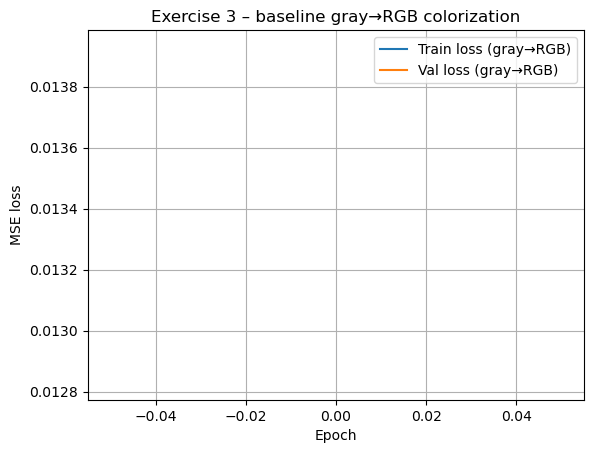

In [ ]:
# --- Cell: plot baseline loss curves ---
import matplotlib.pyplot as plt

plt.figure()
plt.plot(train_losses_c, label="Train loss (gray→RGB)")
plt.plot(val_losses_c,   label="Val loss (gray→RGB)")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.legend()
plt.grid(True)
plt.title("Exercise 3 – baseline gray→RGB colorization")
plt.show()


In [ ]:
# --- Cell: evaluation helper ---
def evaluate_mse(model, loader, criterion, device):
    model.eval()
    total = 0.0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            y_hat, _ = model(x)
            loss = criterion(y_hat, y)
            total += loss.item() * x.size(0)
    return total / len(loader.dataset)

test_mse_c = evaluate_mse(model_c, test_loader_c, criterion, device)
print(f"Baseline gray→RGB Test MSE: {test_mse_c:.6f}")


Baseline gray→RGB Test MSE: 0.012743


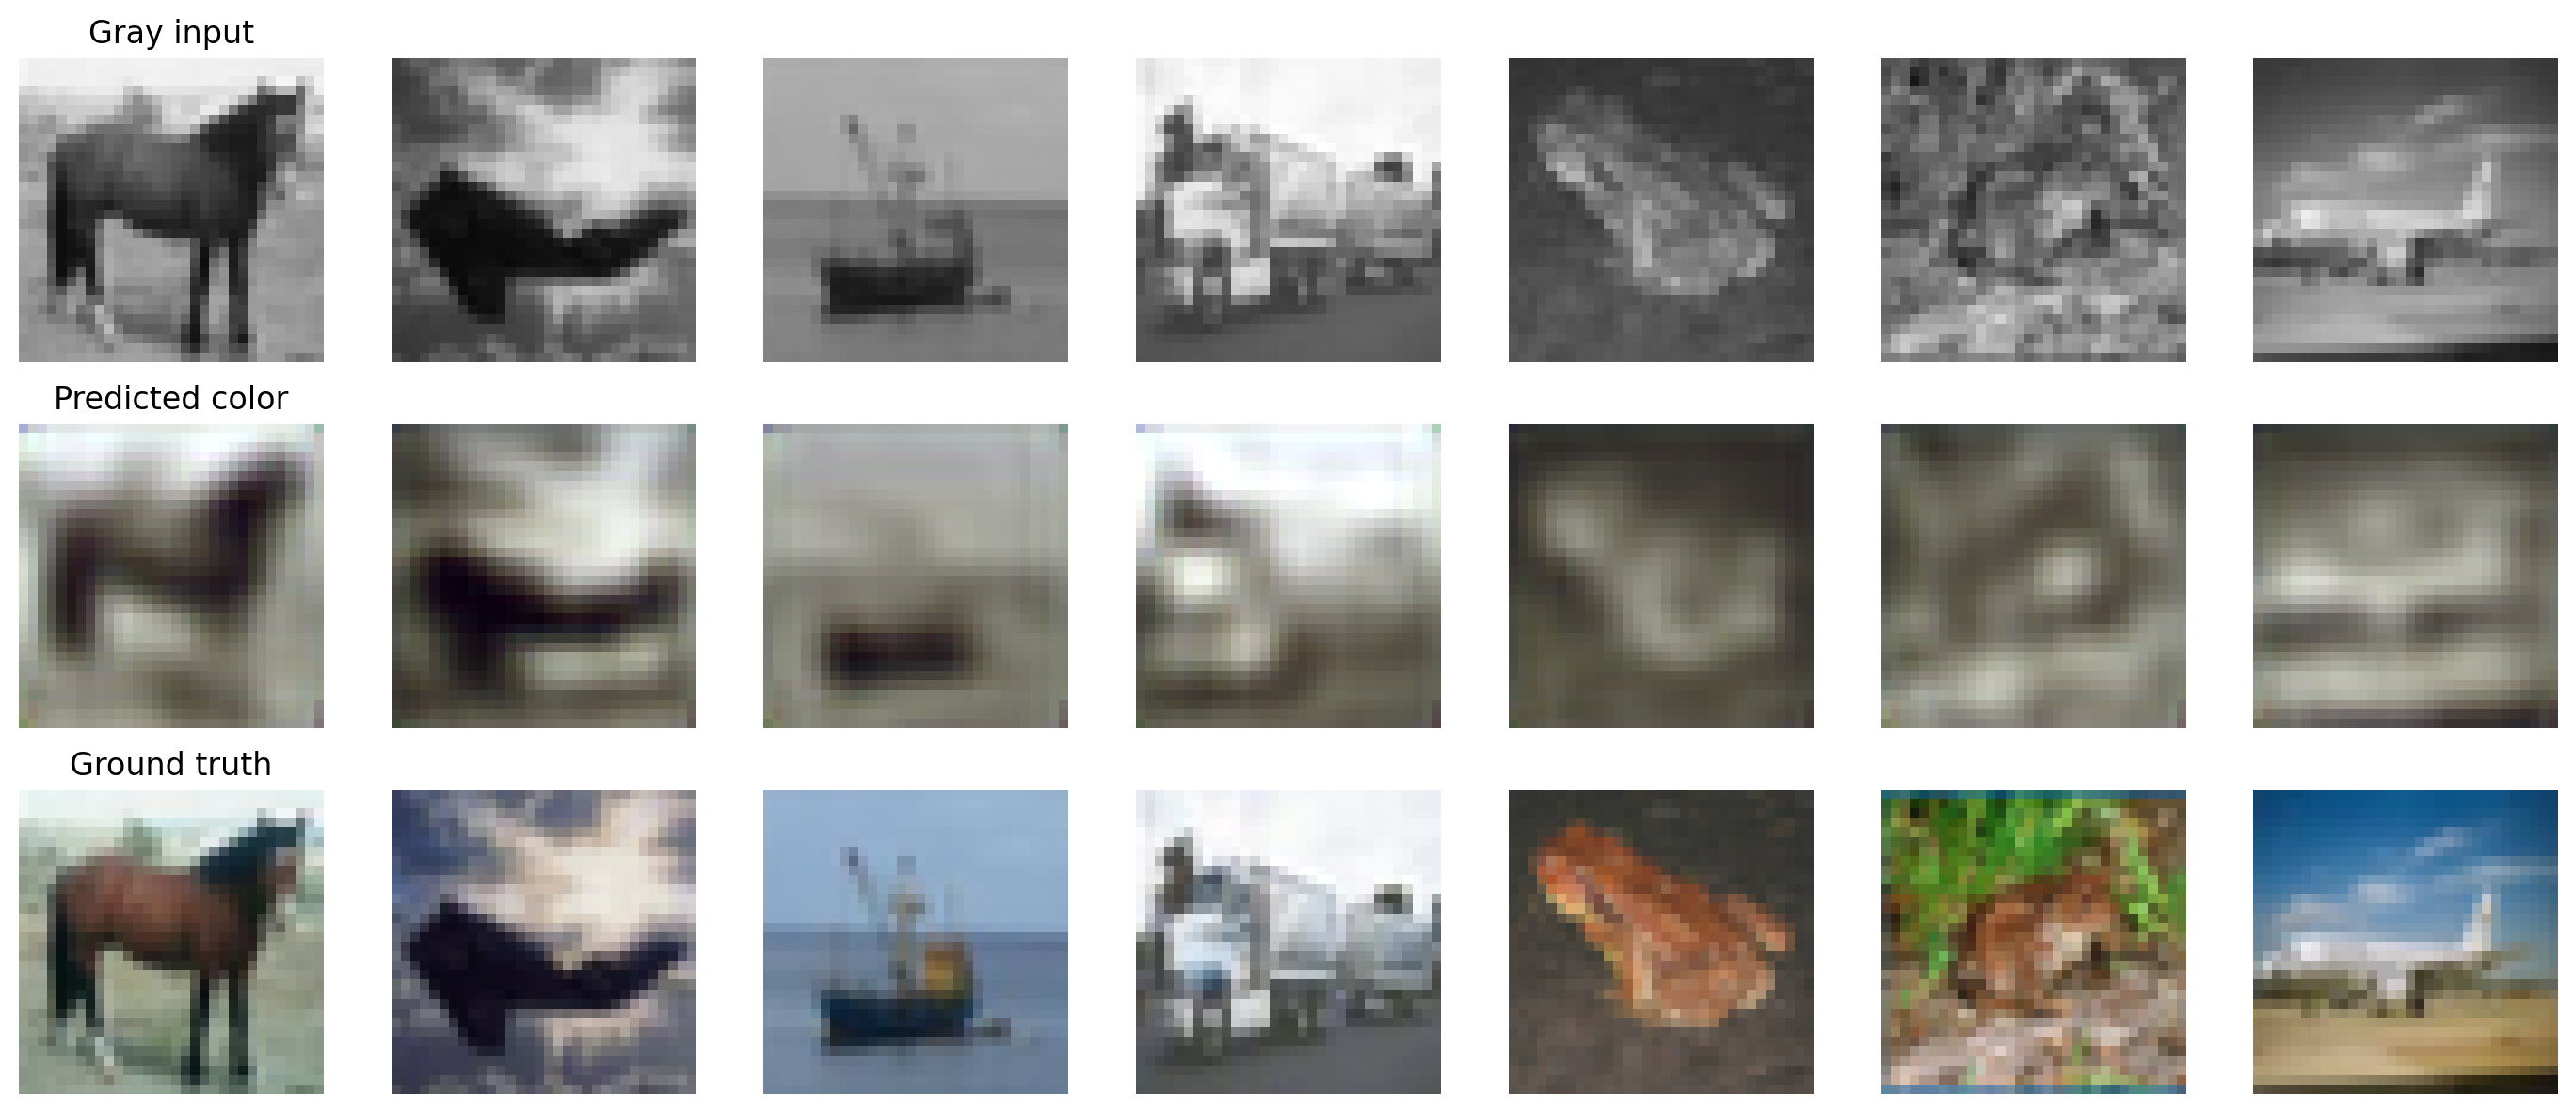

In [ ]:
# --- Cell: visualise baseline colorization ---
model_c.eval()
xg, yg = next(iter(test_loader_c))  # grayscale batch, RGB batch
xg = xg.to(device)
yg = yg.to(device)

with torch.no_grad():
    yp, _ = model_c(xg)

gray = xg[:7].cpu().numpy().transpose(0,2,3,1)
pred = yp[:7].cpu().numpy().transpose(0,2,3,1).clip(0,1)
true = yg[:7].cpu().numpy().transpose(0,2,3,1)

fig, ax = plt.subplots(3, 7, figsize=(14, 6), dpi=200)
for i in range(7):
    ax[0, i].imshow(gray[i]); ax[0, i].axis('off')
    ax[1, i].imshow(pred[i]); ax[1, i].axis('off')
    ax[2, i].imshow(true[i]); ax[2, i].axis('off')

ax[0, 0].set_title("Gray input")
ax[1, 0].set_title("Predicted color")
ax[2, 0].set_title("Ground truth")
plt.tight_layout()
plt.show()


## 3.2 Chrominance-only colorization (hint)

We now follow the hint from the lab sheet and work in the YCbCr colour space:

- Each RGB image is converted to YCbCr.
- **Input**: luminance channel Y (grayscale), shape [1, 32, 32]
- **Target**: chrominance channels [Cb, Cr], shape [2, 32, 32]
- The network predicts only (Cb, Cr). We then combine Y with predicted
  chrominance and convert back to RGB for visualization.


In [ ]:
# --- Cell: dataset for chrominance-only colorization ---
from PIL import Image

class YCbCrChrominanceCIFAR(Dataset):
    """
    Returns:
      Y:   luminance channel, shape [1, 32, 32], in [0,1]
      CbCr: two chrominance channels, shape [2, 32, 32], in [0,1]
    """
    def __init__(self, baseds):
        self.baseds = baseds
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.baseds)

    def __getitem__(self, idx):
        img, _ = self.baseds[idx]      # PIL RGB
        ycbcr = img.convert("YCbCr")   # PIL YCbCr
        Y, Cb, Cr = ycbcr.split()

        Y_t   = self.to_tensor(Y)      # [1,H,W]
        Cb_t  = self.to_tensor(Cb)     # [1,H,W]
        Cr_t  = self.to_tensor(Cr)     # [1,H,W]
        CbCr_t = torch.cat([Cb_t, Cr_t], dim=0)  # [2,H,W]

        return Y_t, CbCr_t

# Build full dataset and split 80/10/10
all_yc = ConcatDataset([
    YCbCrChrominanceCIFAR(base_train),
    YCbCrChrominanceCIFAR(base_test)
])

n = len(all_yc)
n_train = int(0.8 * n)
n_val   = int(0.1 * n)
n_test  = int(0.1 * n)

train_set_ch, val_set_ch, test_set_ch = random_split(all_yc, [n_train, n_val, n_test])

train_loader_ch = DataLoader(train_set_ch, batch_size=batch_size, shuffle=True,  num_workers=0)
val_loader_ch   = DataLoader(val_set_ch,   batch_size=batch_size, shuffle=False, num_workers=0)
test_loader_ch  = DataLoader(test_set_ch,  batch_size=batch_size, shuffle=False, num_workers=0)

print("Chrominance-only dataset sizes:",
      len(train_set_ch), len(val_set_ch), len(test_set_ch))


Chrominance-only dataset sizes: 48000 6000 6000


In [ ]:
# --- Cell: Y->CbCr autoencoder ---
class ChrominanceAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder: 1 -> 8 -> 12 -> 16
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),           # 32 -> 16

            nn.Conv2d(8, 12, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),           # 16 -> 8

            nn.Conv2d(12, 16, kernel_size=3, padding=1),
            nn.ReLU(),                    # latent: [16, 8, 8]
        )

        # Decoder: 16 -> 12 -> 2 (Cb, Cr)
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),   # 8 -> 16
            nn.Conv2d(16, 12, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.Upsample(scale_factor=2, mode="nearest"),   # 16 -> 32
            nn.Conv2d(12, 2, kernel_size=3, padding=1),
            nn.Sigmoid()   # Cb/Cr normalised to [0,1]
        )

    def forward(self, x):
        h = self.encoder(x)
        out = self.decoder(h)
        return out, h

model_ch = ChrominanceAutoEncoder().to(device)
criterion_ch = nn.MSELoss()
optimizer_ch = optim.Adam(model_ch.parameters(), lr=1e-3)
epochs_ch = 50

print("Chrominance model on:", device)


Chrominance model on: cpu


In [ ]:
# --- Cell: train chrominance-only colorizer ---
train_losses_ch = []
val_losses_ch = []

print()
print(f"{'Epoch':>5} | {'Train MSE':>10} | {'Val MSE':>10}")
print("-" * 32)

for e in range(1, epochs_ch + 1):
    # ---- TRAIN ----
    model_ch.train()
    running_train = 0.0

    for Y, CbCr in train_loader_ch:
        Y    = Y.to(device)      # [B,1,H,W]
        CbCr = CbCr.to(device)   # [B,2,H,W]

        optimizer_ch.zero_grad()
        pred_CbCr, _ = model_ch(Y)
        loss = criterion_ch(pred_CbCr, CbCr)
        loss.backward()
        optimizer_ch.step()

        running_train += loss.item() * Y.size(0)

    epoch_train = running_train / len(train_loader_ch.dataset)
    train_losses_ch.append(epoch_train)

    # ---- VALIDATION ----
    model_ch.eval()
    running_val = 0.0
    with torch.no_grad():
        for Y, CbCr in val_loader_ch:
            Y    = Y.to(device)
            CbCr = CbCr.to(device)
            pred_CbCr, _ = model_ch(Y)
            vloss = criterion_ch(pred_CbCr, CbCr)
            running_val += vloss.item() * Y.size(0)

    epoch_val = running_val / len(val_loader_ch.dataset)
    val_losses_ch.append(epoch_val)

    print(f"{e:5d} | {epoch_train:10.6f} | {epoch_val:10.6f}")



Epoch |  Train MSE |    Val MSE
--------------------------------
    1 |   0.003264 |   0.003030


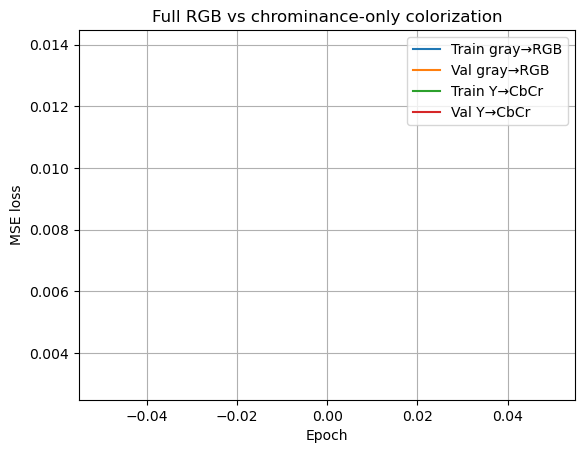

In [ ]:
# --- Cell: overlay loss curves ---
plt.figure()
plt.plot(train_losses_c,  label="Train gray→RGB")
plt.plot(val_losses_c,    label="Val gray→RGB")
plt.plot(train_losses_ch, label="Train Y→CbCr")
plt.plot(val_losses_ch,   label="Val Y→CbCr")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.legend()
plt.grid(True)
plt.title("Full RGB vs chrominance-only colorization")
plt.show()


In [ ]:
# --- Cell: test MSE for chrominance model ---
def evaluate_mse_chroma(model, loader, criterion, device):
    model.eval()
    total = 0.0
    with torch.no_grad():
        for Y, CbCr in loader:
            Y    = Y.to(device)
            CbCr = CbCr.to(device)
            pred_CbCr, _ = model(Y)
            loss = criterion(pred_CbCr, CbCr)
            total += loss.item() * Y.size(0)
    return total / len(loader.dataset)

test_mse_ch = evaluate_mse_chroma(model_ch, test_loader_ch, criterion_ch, device)
print(f"Baseline gray→RGB Test MSE:        {test_mse_c:.6f}")
print(f"Chrominance-only (Y→CbCr) Test MSE: {test_mse_ch:.6f}")


Baseline gray→RGB Test MSE:        0.012743
Chrominance-only (Y→CbCr) Test MSE: 0.003081


In [ ]:
# --- Cell: helper to convert Y + CbCr tensors back to RGB tensors ---
from torchvision.transforms.functional import to_pil_image

def ycbcr_tensors_to_rgb_batch(Y, CbCr):
    """
    Y:   [B,1,H,W] in [0,1]
    CbCr:[B,2,H,W] in [0,1]
    returns: [B,3,H,W] RGB tensors in [0,1]
    """
    to_tensor = transforms.ToTensor()
    imgs = []
    B = Y.size(0)
    for i in range(B):
        y_pil  = to_pil_image(Y[i])          # 'L'
        cb_pil = to_pil_image(CbCr[i,0:1])   # 'L'
        cr_pil = to_pil_image(CbCr[i,1:2])   # 'L'

        ycbcr_pil = Image.merge("YCbCr", (y_pil, cb_pil, cr_pil))
        rgb_pil   = ycbcr_pil.convert("RGB")
        rgb_t     = to_tensor(rgb_pil)       # [3,H,W] in [0,1]
        imgs.append(rgb_t)

    return torch.stack(imgs, dim=0)


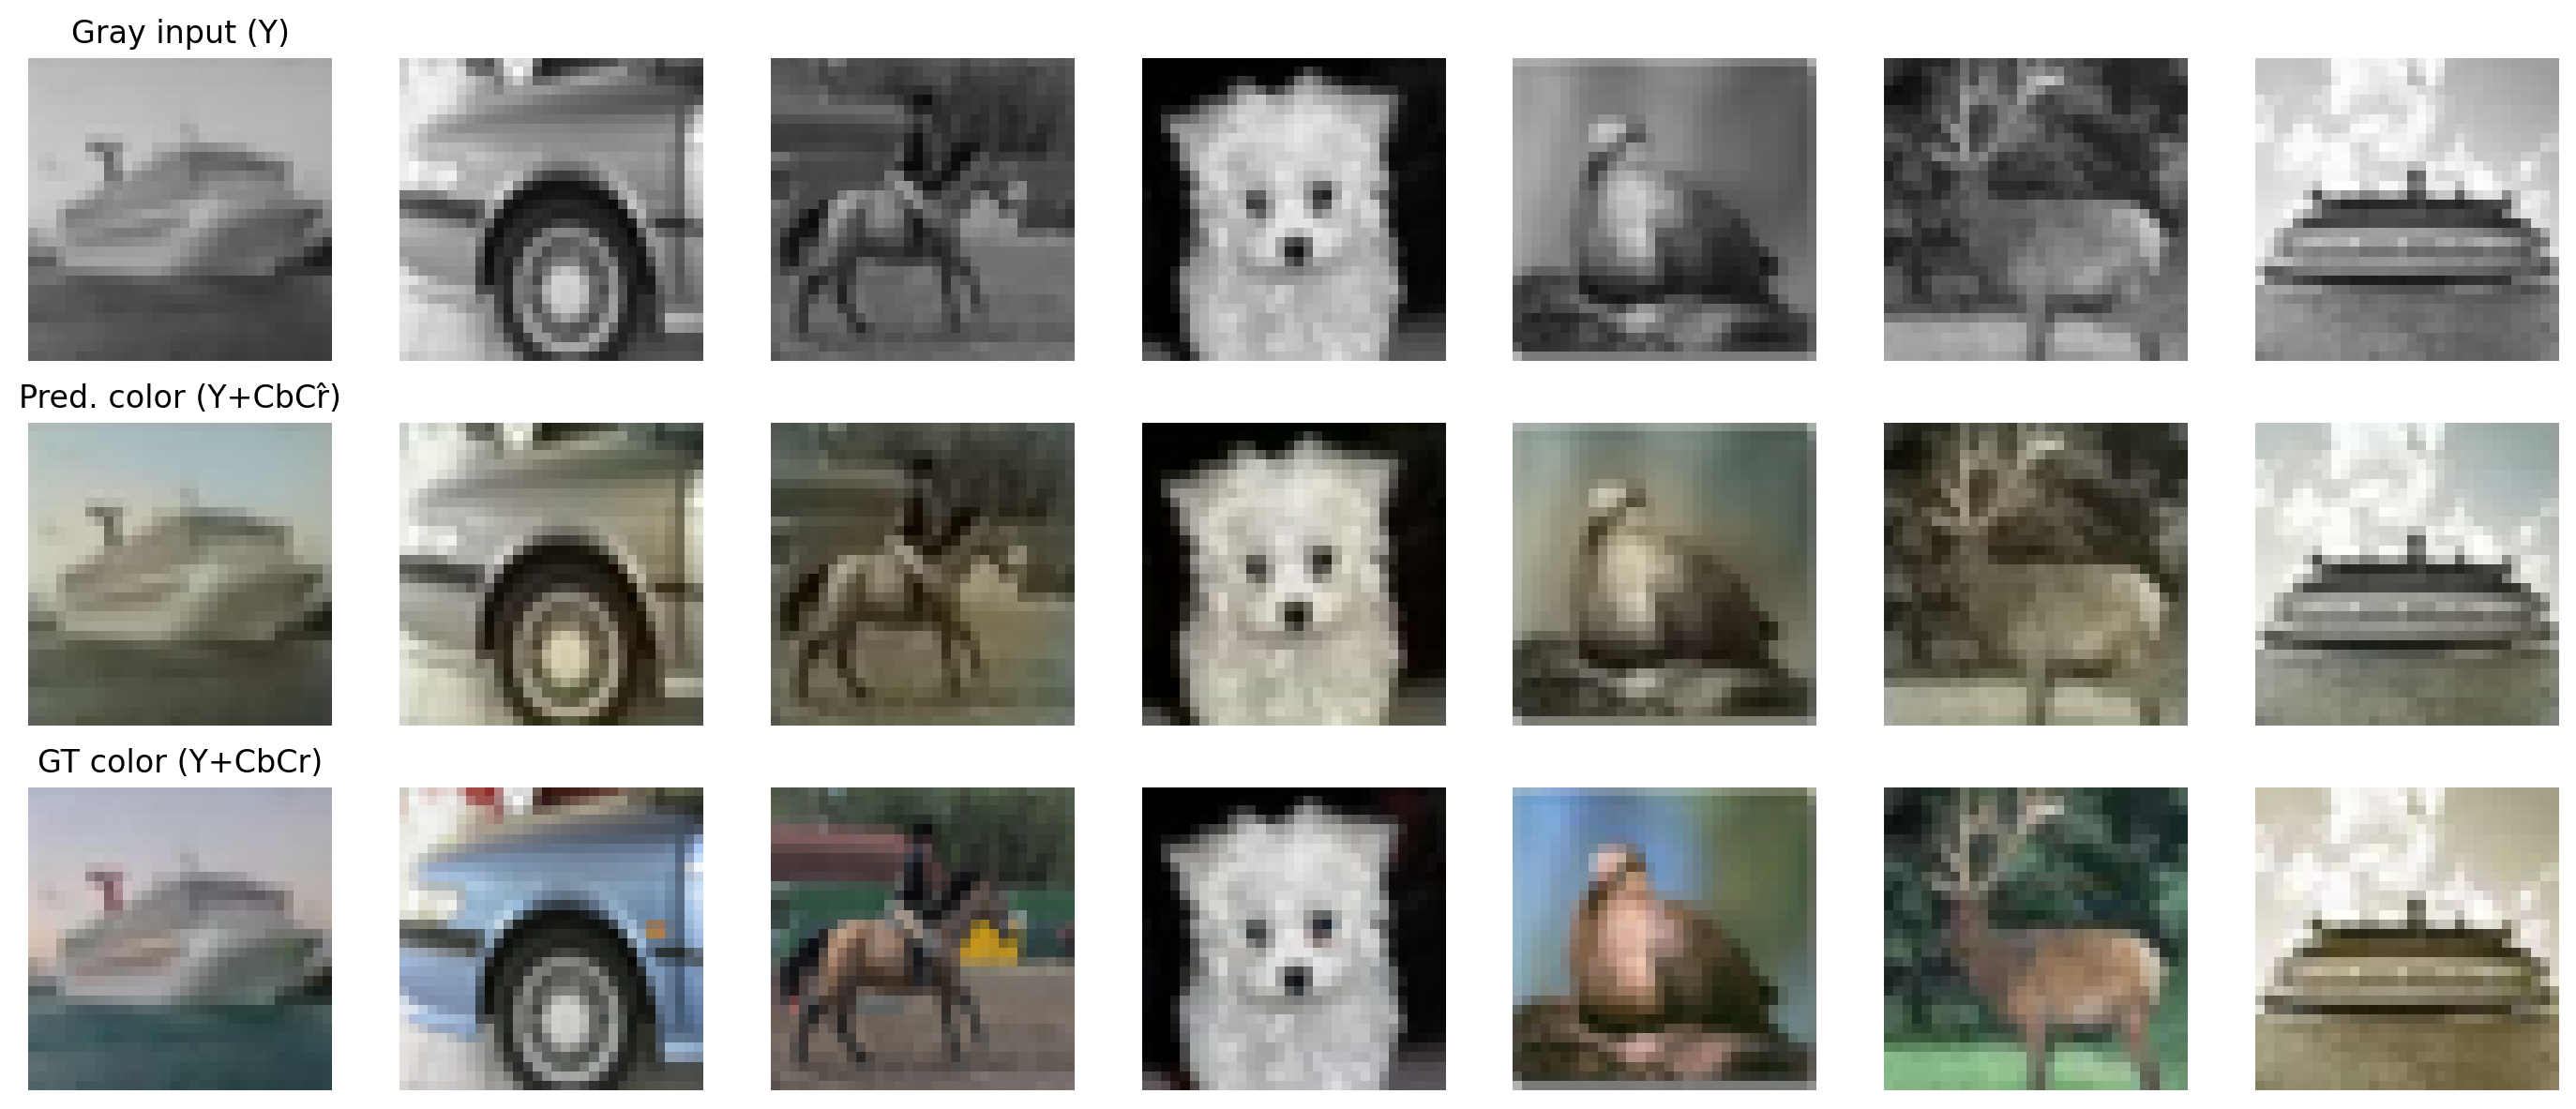

In [ ]:
# --- Cell: visualise chrominance-only colorization ---
model_ch.eval()
Y_batch, CbCr_batch = next(iter(test_loader_ch))
Y_batch    = Y_batch.to(device)
CbCr_batch = CbCr_batch.to(device)

with torch.no_grad():
    pred_CbCr_batch, _ = model_ch(Y_batch)

Y_cpu        = Y_batch.cpu()
CbCr_true    = CbCr_batch.cpu()
CbCr_pred    = pred_CbCr_batch.cpu().clamp(0, 1)

rgb_true = ycbcr_tensors_to_rgb_batch(Y_cpu, CbCr_true)
rgb_pred = ycbcr_tensors_to_rgb_batch(Y_cpu, CbCr_pred)

gray_rgb = Y_cpu.repeat(1, 3, 1, 1)

k = 7
fig, ax = plt.subplots(3, k, figsize=(14, 6), dpi=200)
for i in range(k):
    ax[0, i].imshow(gray_rgb[i].numpy().transpose(1, 2, 0))
    ax[0, i].axis('off')
    ax[1, i].imshow(rgb_pred[i].numpy().transpose(1, 2, 0))
    ax[1, i].axis('off')
    ax[2, i].imshow(rgb_true[i].numpy().transpose(1, 2, 0))
    ax[2, i].axis('off')

ax[0, 0].set_title("Gray input (Y)")
ax[1, 0].set_title("Pred. color (Y+CbCr̂)")
ax[2, 0].set_title("GT color (Y+CbCr)")
plt.tight_layout()
plt.show()
